Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/ch/d3fhv7gn783gkmwyt9vzp4sm0000gn/T/ipykernel_46589/3700632212.py:223: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value 

Checkpoint loaded successfully. Classifier layer is randomly initialized unless you fine-tuned it.


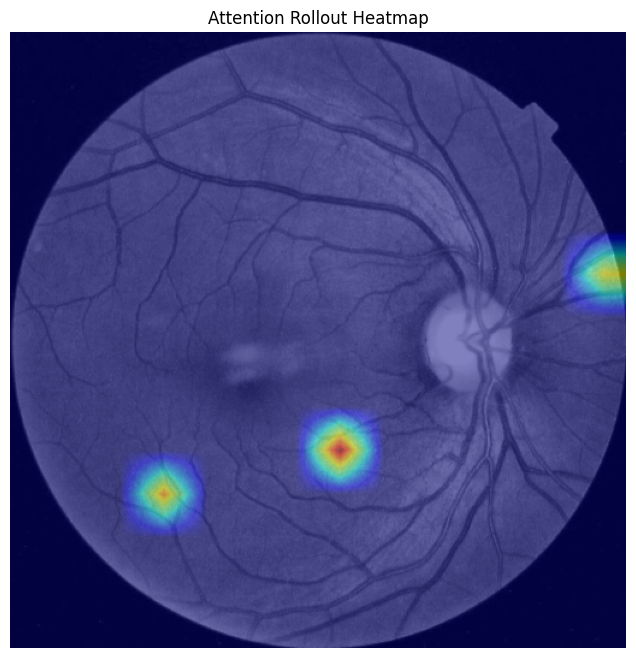

In [26]:
# Grad-Cam with heatmaps that are pretty cooked, did some parameter adjusting and still sucks lowkey

import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import math
import torch.nn as nn
from transformers import ViTForImageClassification
from torchvision import transforms

##############################################################################
# 1. RetinalClassifier class remains mostly the same. Just ensure your model
#    is well-finetuned on your retinal dataset for attention maps to be meaningful.
##############################################################################
class RetinalClassifier:
    def __init__(self, num_classes=5):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Load pre-trained model while ignoring classifier size mismatch
        self.model = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224',
            num_labels=num_classes,
            ignore_mismatched_sizes=True  # Prevents classifier size errors
        ).to(self.device)

        # Replace classifier layer
        self.model.classifier = torch.nn.Linear(self.model.config.hidden_size, num_classes).to(self.device)

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def predict(self, image_path):
        self.model.eval()
        image = Image.open(image_path).convert('RGB')
        image = self.transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            outputs = self.model(image).logits
            _, predicted = torch.max(outputs, 1)
            
        return predicted.item()

##############################################################################
# 2. Compute Attention Rollout with optional tweaks:
#    - 'discard_ratio': discards the lowest fraction of attention weights.
#    - 'add_identity': controls whether to add the identity matrix at each block
#                      (accounting for residuals).
#    - 'rollout_all_layers': if False, only uses the last layer's attention.
##############################################################################
def compute_attention_rollout(
    attentions,
    discard_ratio=0.0,
    add_identity=True,
    rollout_all_layers=True
):
    """
    Computes the attention rollout from a tuple of attention matrices.

    Args:
        attentions (tuple): Attention matrices from each transformer block.
        discard_ratio (float): Fraction of the lowest attention weights to discard.
        add_identity (bool): If True, add the identity matrix each layer (Chefer approach).
        rollout_all_layers (bool): If False, only use the last layer's attention
                                   instead of multiplying across all layers.

    Returns:
        result (torch.Tensor): The cumulative attention rollout (batch_size x seq_len x seq_len).
    """
    device = attentions[0].device
    
    # Optionally use all layers or just the last layer
    if not rollout_all_layers:
        # Only keep the last attention block
        attentions = [attentions[-1]]

    # Initialize rollout as an identity matrix
    result = torch.eye(attentions[0].size(-1), device=device).unsqueeze(0)

    for attention in attentions:
        # Average over all heads => [batch_size, seq_len, seq_len]
        attn_heads_fused = attention.mean(dim=1)
        
        # Optionally add identity to account for residual connections
        if add_identity:
            attn_heads_fused = attn_heads_fused + torch.eye(attn_heads_fused.size(-1), device=device)
        
        # Normalize each row
        attn_heads_fused = attn_heads_fused / attn_heads_fused.sum(dim=-1, keepdim=True)
        
        # Optionally discard a portion of the lowest attention values
        if discard_ratio > 0:
            flat = attn_heads_fused.view(attn_heads_fused.size(0), -1)
            # Number of values to discard
            num_to_discard = int(flat.size(-1) * discard_ratio)
            _, indices = flat.topk(num_to_discard, dim=-1, largest=False)
            flat.scatter_(1, indices, 0)
            attn_heads_fused = flat.view_as(attn_heads_fused)

        # Multiply the attention matrices
        result = torch.bmm(result, attn_heads_fused)
    
    return result


##############################################################################
# 3. explain_model with optional post-processing:
#    - 'discard_ratio' can be > 0 to sharpen the map
#    - 'rollout_all_layers' or 'add_identity' toggles different rollout modes
#    - We apply min-max normalization to the heatmap
#    - We optionally apply a threshold to highlight top attention areas
##############################################################################
def explain_model(
    retinal_classifier,
    image_path,
    discard_ratio=0.0,
    add_identity=True,
    rollout_all_layers=True,
    threshold=None,
    visualize=True
):
    """
    Generates an attention rollout heatmap for a given image using a loaded model.
    
    Args:
        retinal_classifier: An instance of your RetinalClassifier (with a loaded model).
        image_path (str): Path to the image to explain.
        discard_ratio (float): Fraction of the lowest attention weights to discard.
        add_identity (bool): Whether to add identity at each layer (residual).
        rollout_all_layers (bool): If False, only the last layer is used.
        threshold (float): If set, we zero out heatmap values below this fraction.
        visualize (bool): If True, display the heatmap overlay on the image.

    Returns:
        heatmap (numpy.ndarray): A 2D array representing the attention heatmap.
    """
    model = retinal_classifier.model
    model.eval()
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    device = next(model.parameters()).device
    input_tensor = transform(image).unsqueeze(0).to(device)
    
    # Forward pass with attention outputs enabled
    outputs = model(input_tensor, output_attentions=True)
    attentions = outputs.attentions  # Tuple of attention matrices from each transformer block
    
    # Compute the cumulative attention rollout
    rollout = compute_attention_rollout(
        attentions,
        discard_ratio=discard_ratio,
        add_identity=add_identity,
        rollout_all_layers=rollout_all_layers
    )
    
    # Extract attention from the class token (index 0) to the patch tokens (indices 1:)
    # Make sure your model uses [CLS] at index 0. This is standard for ViT.
    class_attention = rollout[0, 0, 1:]  # shape [patch_count]
    
    # For ViT-base with patch size 16 on 224x224, we get a 14x14 grid.
    grid_size = int(class_attention.shape[0] ** 0.5)
    heatmap = class_attention.reshape(grid_size, grid_size).detach().cpu().numpy()
    
    # -----------------------------
    # Optional: Min-max normalize
    # -----------------------------
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    
    # -----------------------------
    # Optional: Threshold
    # -----------------------------
    if threshold is not None:
        heatmap[heatmap < threshold] = 0.0

    # -----------------------------
    # Visualization
    # -----------------------------
    if visualize:
        # Resize heatmap to the original image size for overlay using cv2.
        # NOTE: This can distort if the original image isn't square.
        #       You might consider center-cropping or ensuring your input is always square.
        heatmap_resized = cv2.resize(heatmap, image.size)
        
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        # Overlay the heatmap with a chosen colormap and some transparency
        plt.imshow(heatmap_resized, cmap='jet', alpha=0.5)
        plt.title("Attention Rollout Heatmap")
        plt.axis('off')
        plt.show()
    
    return heatmap


##############################################################################
# 4. Main driver script usage example.
#    Be sure you have fine-tuned the model so the attention maps are meaningful.
##############################################################################
if __name__ == "__main__":
    from transformers.models.vit.configuration_vit import ViTConfig
    import torch

    torch.serialization.add_safe_globals([ViTConfig])

    # Create an instance of your classifier
    model = RetinalClassifier()

    # Load model checkpoint
    # Ensure this checkpoint is from a well-finetuned model, or else attention maps won't be very informative.
    checkpoint = torch.load('best_model.pth', map_location=torch.device('cpu'))
    # Remove classifier parameters from the checkpoint (if needed)
    filtered_checkpoint = {
        k: v for k, v in checkpoint['model_state_dict'].items() 
        if not k.startswith("classifier")
    }
    model.model.load_state_dict(filtered_checkpoint, strict=False)
    print("Checkpoint loaded successfully. Classifier layer is randomly initialized unless you fine-tuned it.")

    # Path to the image you want to explain
    image_path = "/Users/tanishroy/Desktop/School/Third year/Retinal-Disease-Detection-main/APTOS 2019 Blindness Detection Segmented/train_images/d30d079e6f9a.png"
    
    # Generate and display the explanation heatmap with some recommended parameters:
    # - discard_ratio=0.1 to remove the bottom 10% of attention weights
    # - threshold=0.3 to zero out low-intensity patches in the final heatmap
    # - rollout_all_layers=True (use all layers) or False (just the last layer)
    heatmap = explain_model(
        model,
        image_path,
        discard_ratio=0.1,
        add_identity=True,
        rollout_all_layers=True,
        threshold=0.3,
        visualize=True
    )


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/ch/d3fhv7gn783gkmwyt9vzp4sm0000gn/T/ipykernel_46589/2034976328.py:79: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value f

Checkpoint loaded successfully.


PartitionExplainer explainer: 2it [00:36, 36.69s/it]               


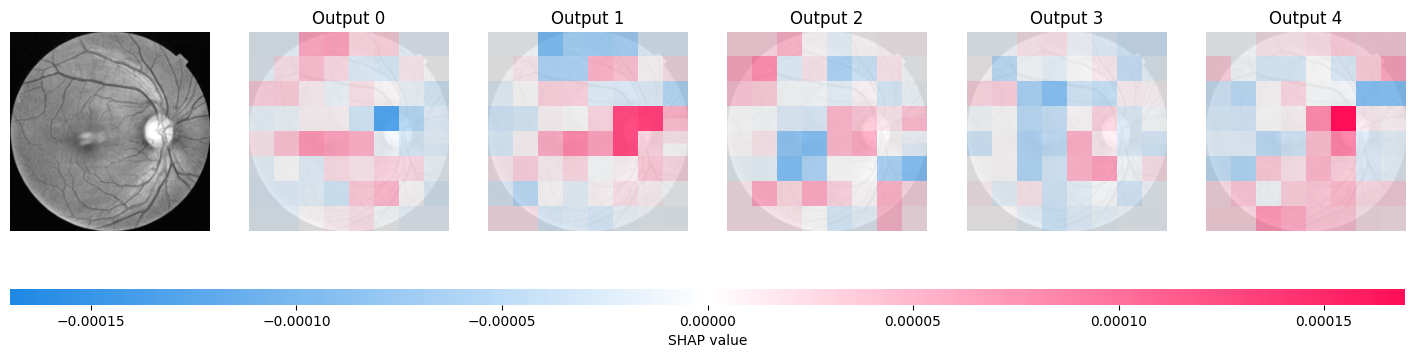

In [27]:
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from transformers import ViTForImageClassification
from shap.maskers import Image as ImageMasker

# ✅ Step 1: Define the model architecture
class RetinalClassifier:
    def __init__(self, num_classes=5):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224',
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        ).to(self.device)

        self.model.classifier = torch.nn.Linear(self.model.config.hidden_size, num_classes).to(self.device)

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])


# ✅ Step 2: SHAP wrapper
class SHAPExplainer:
    def __init__(self, model_wrapper):
        self.device = model_wrapper.device
        self.model_wrapper = model_wrapper
        self.model_wrapper.model.eval()
        self.model = model_wrapper.model
        self.transform = model_wrapper.transform

    def predict_numpy(self, images):
        inputs = []
        for img in images:
            img_pil = Image.fromarray((img * 255).astype(np.uint8))
            img_tensor = self.transform(img_pil).unsqueeze(0)
            inputs.append(img_tensor)
        inputs = torch.cat(inputs).to(self.device)
        with torch.no_grad():
            logits = self.model(inputs).logits
        return logits.cpu().numpy()

    # ✅ Moved inside the class
    def explain_image(self, image_path, visualize=True):
        image = Image.open(image_path).convert('RGB').resize((224, 224))
        image_np = np.array(image).astype(np.float32) / 255.0

        # SHAP masker (SHAP handles segmentation internally)
        masker = ImageMasker(mask_value=0.0, shape=image_np.shape)

        # SHAP explainer
        explainer = shap.Explainer(self.predict_numpy, masker)

        # Run SHAP
        shap_values = explainer(image_np[np.newaxis, ...])

        if visualize:
            shap.image_plot(shap_values, show=True)

        return shap_values


# ✅ Step 3: Load model, checkpoint, and explain
if __name__ == "__main__":
    torch.manual_seed(0)

    # Initialize model
    model = RetinalClassifier()

    # Load your fine-tuned weights
    checkpoint = torch.load('best_model.pth', map_location=torch.device('cpu'))
    filtered_checkpoint = {
        k: v for k, v in checkpoint['model_state_dict'].items()
        if not k.startswith("classifier")
    }
    model.model.load_state_dict(filtered_checkpoint, strict=False)
    print("Checkpoint loaded successfully.")

    # Initialize SHAP explainer
    shap_explainer = SHAPExplainer(model)

    # Path to your image
    image_path = "/Users/tanishroy/Desktop/School/Third year/Retinal-Disease-Detection-main/APTOS 2019 Blindness Detection Segmented/train_images/d30d079e6f9a.png"

    # Explain
    shap_explainer.explain_image(image_path, visualize=True)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/ch/d3fhv7gn783gkmwyt9vzp4sm0000gn/T/ipykernel_46589/2039175224.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value f

Checkpoint loaded successfully.


100%|██████████| 1000/1000 [01:19<00:00, 12.53it/s]


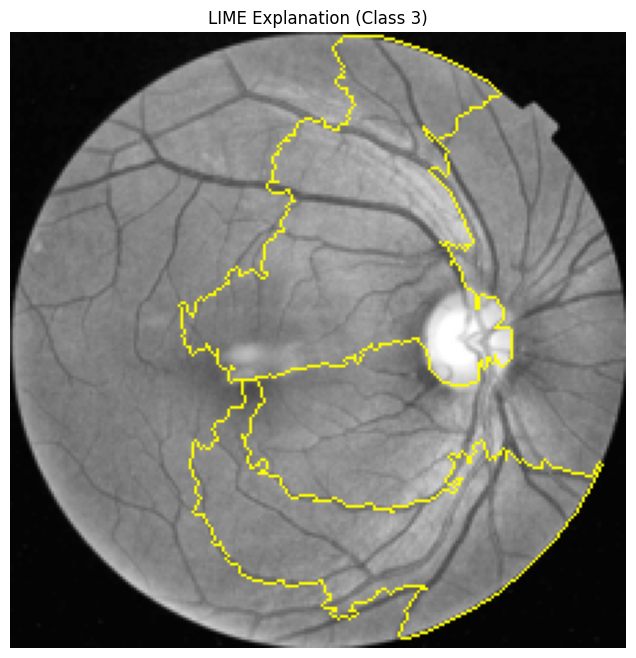

In [28]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from transformers import ViTForImageClassification
from lime import lime_image
from skimage.segmentation import mark_boundaries


# ✅ Step 1: Define your model architecture
class RetinalClassifier:
    def __init__(self, num_classes=5):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224',
            num_labels=num_classes,
            ignore_mismatched_sizes=True
        ).to(self.device)

        self.model.classifier = torch.nn.Linear(self.model.config.hidden_size, num_classes).to(self.device)

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def predict(self, pil_image):
        image_tensor = self.transform(pil_image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            logits = self.model(image_tensor).logits
        return torch.argmax(logits, dim=1).item()


# ✅ Step 2: Define LIME explanation logic
class LIMEExplainer:
    def __init__(self, model_wrapper):
        self.model_wrapper = model_wrapper
        self.model = model_wrapper.model
        self.device = model_wrapper.device
        self.transform = model_wrapper.transform
        self.model.eval()

    def predict_numpy(self, imgs):
        imgs_tensor = []
        for img in imgs:
            pil_img = Image.fromarray((img * 255).astype(np.uint8))
            tensor_img = self.transform(pil_img).unsqueeze(0)
            imgs_tensor.append(tensor_img)
        batch = torch.cat(imgs_tensor).to(self.device)
        with torch.no_grad():
            logits = self.model(batch).logits
        return logits.cpu().numpy()

    def explain_image(self, image_path, num_samples=1000, visualize=True):
        image = Image.open(image_path).convert('RGB').resize((224, 224))
        image_np = np.array(image).astype(np.float32) / 255.0

        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(
            image_np,
            classifier_fn=self.predict_numpy,
            top_labels=1,
            hide_color=0,
            num_samples=num_samples
        )

        pred_class = explanation.top_labels[0]
        temp, mask = explanation.get_image_and_mask(
            label=pred_class,
            positive_only=True,
            hide_rest=False,
            num_features=10,
            min_weight=0.01
        )

        if visualize:
            plt.figure(figsize=(8, 8))
            plt.imshow(mark_boundaries(temp, mask))
            plt.title(f"LIME Explanation (Class {pred_class})")
            plt.axis('off')
            plt.show()

        return explanation


# ✅ Step 3: Run LIME
if __name__ == "__main__":
    # Load model
    model = RetinalClassifier()
    checkpoint = torch.load('best_model.pth', map_location=torch.device('cpu'))
    filtered_checkpoint = {
        k: v for k, v in checkpoint['model_state_dict'].items()
        if not k.startswith("classifier")
    }
    model.model.load_state_dict(filtered_checkpoint, strict=False)
    print("Checkpoint loaded successfully.")

    # Image path
    image_path = "/Users/tanishroy/Desktop/School/Third year/Retinal-Disease-Detection-main/APTOS 2019 Blindness Detection Segmented/train_images/d30d079e6f9a.png"

    # Explain with LIME
    lime_explainer = LIMEExplainer(model)
    lime_explainer.explain_image(image_path, num_samples=1000, visualize=True)


In [11]:
from pathlib import Path

# Define the directory and load a few images for testing
image_dir = Path("/Users/tanishroy/Desktop/School/Third year/Retinal-Disease-Detection-main/APTOS 2019 Blindness Detection Segmented/train_images/")
image_paths = sorted(list(image_dir.glob("*.png")))[:5]  # Pick first 5 images to experiment

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/ch/d3fhv7gn783gkmwyt9vzp4sm0000gn/T/ipykernel_46589/1718041896.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value f

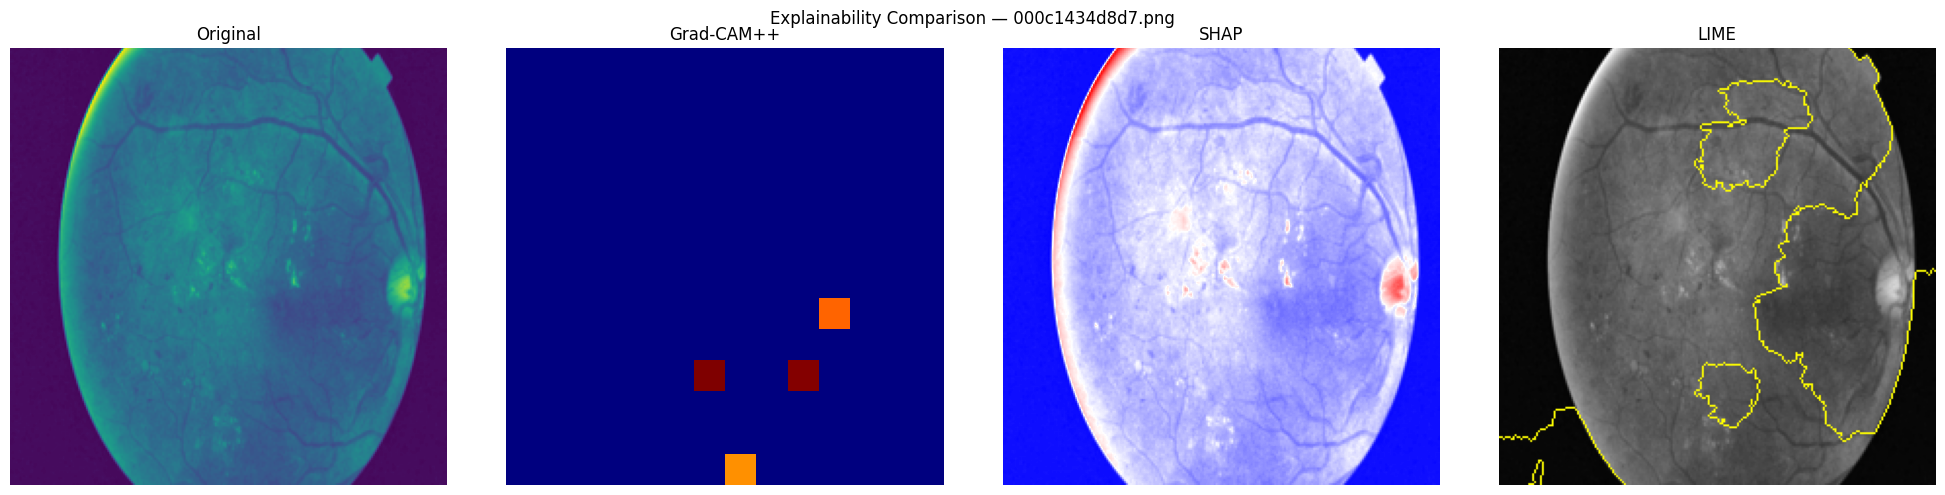

PartitionExplainer explainer: 2it [00:40, 40.12s/it]               04, 106.22s/it]
100%|██████████| 1000/1000 [01:20<00:00, 12.37it/s]


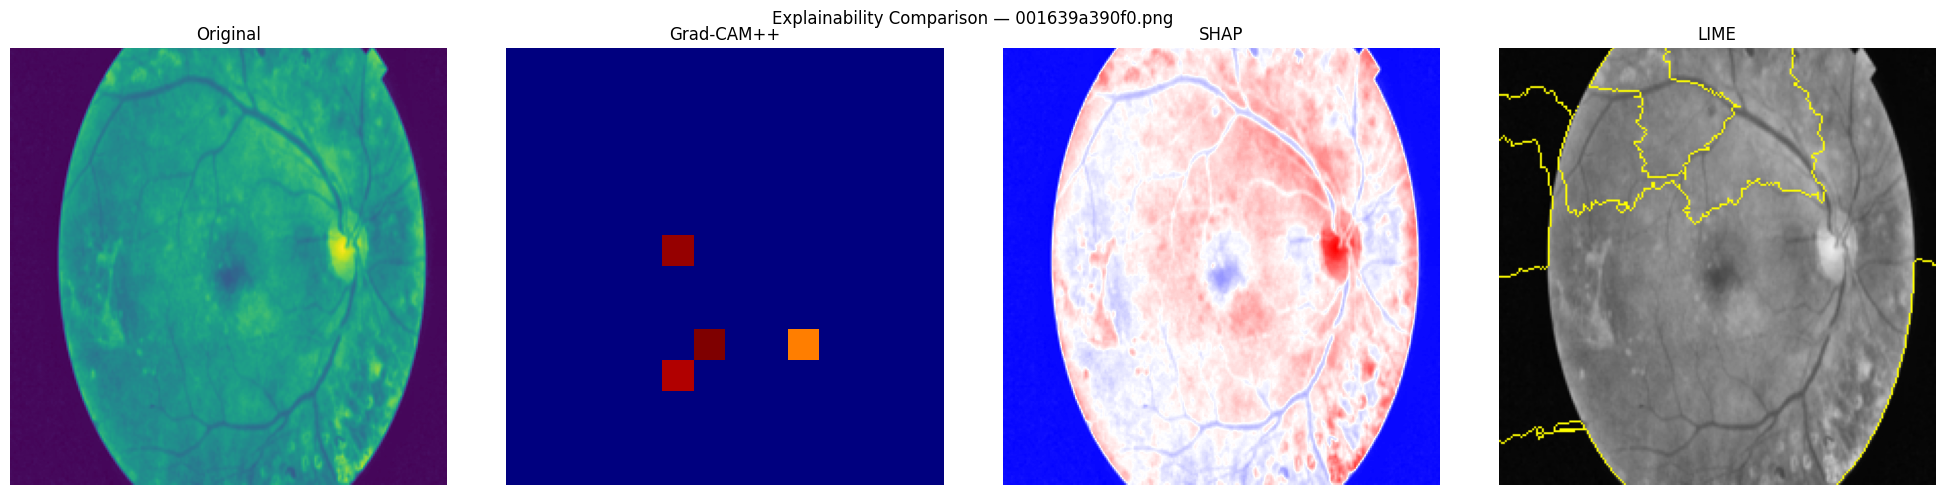

PartitionExplainer explainer: 2it [00:44, 44.16s/it]               47, 115.72s/it]
100%|██████████| 1000/1000 [01:23<00:00, 11.93it/s]


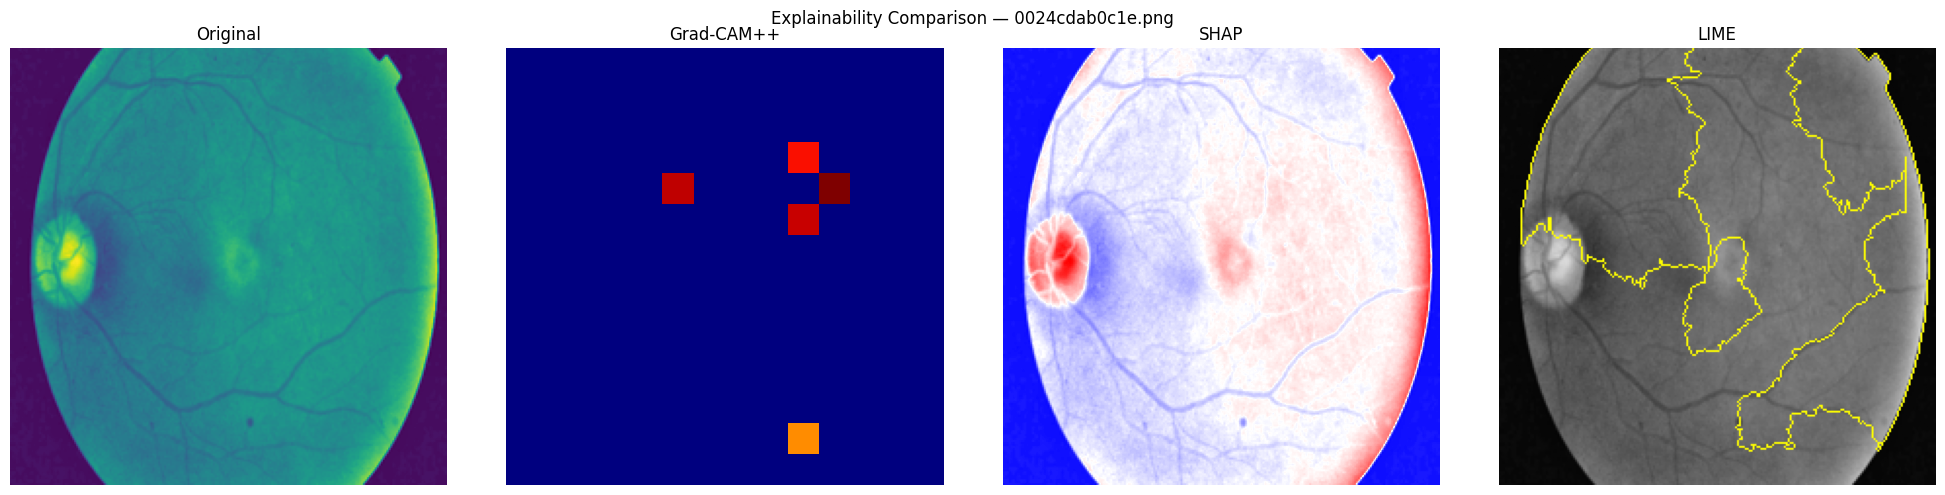

PartitionExplainer explainer: 2it [00:43, 43.31s/it]               03, 121.96s/it]
100%|██████████| 1000/1000 [01:29<00:00, 11.23it/s]


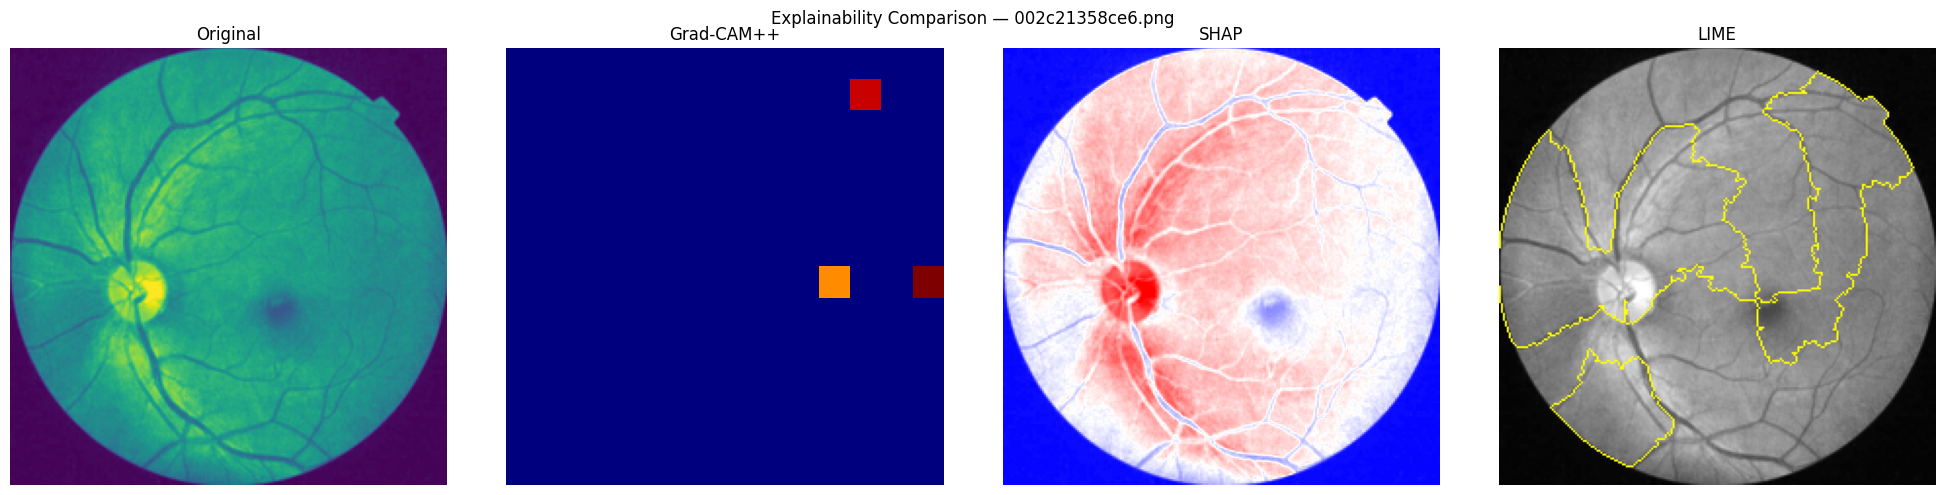

PartitionExplainer explainer: 2it [00:44, 44.33s/it]               06, 126.67s/it]
100%|██████████| 1000/1000 [01:28<00:00, 11.24it/s]


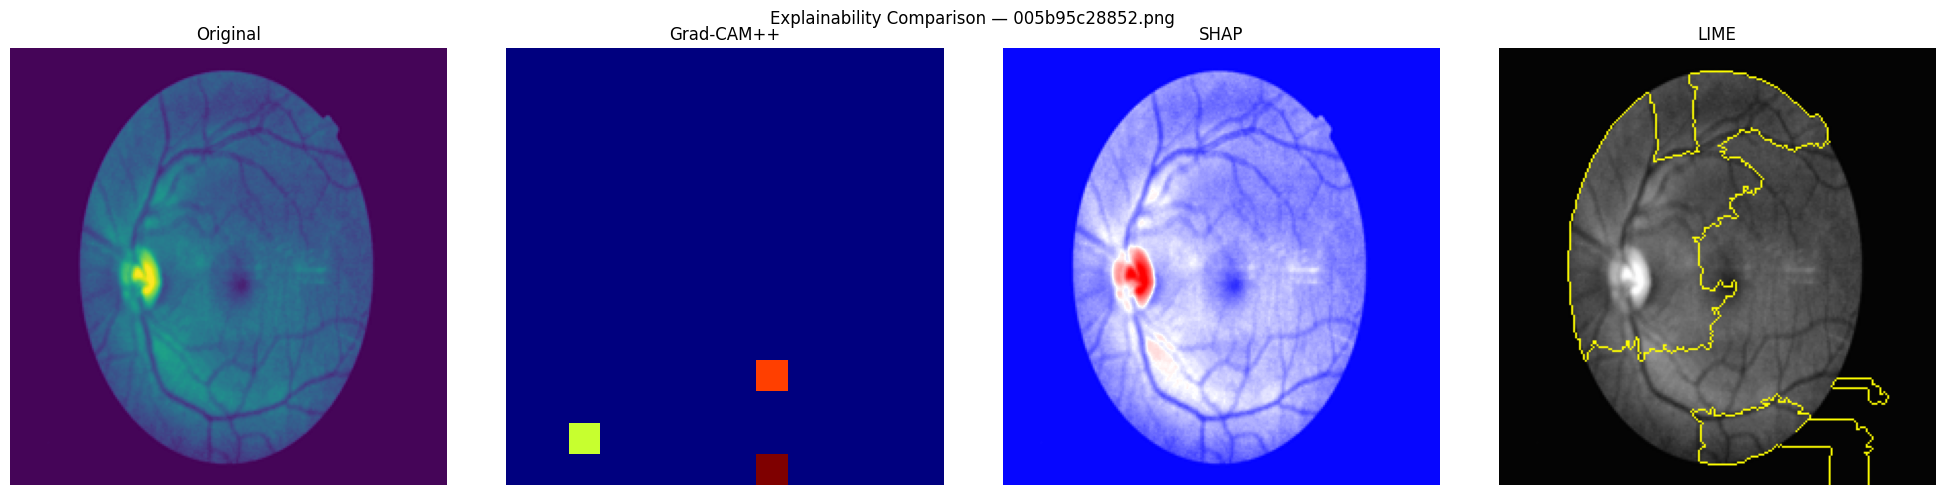

Running Explainability Experiments: 100%|██████████| 5/5 [10:26<00:00, 125.34s/it]


In [16]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
from skimage.segmentation import mark_boundaries
from pathlib import Path

# === Setup test images ===
image_dir = Path("/Users/tanishroy/Desktop/School/Third year/Retinal-Disease-Detection-main/APTOS 2019 Blindness Detection Segmented/train_images/")
image_paths = sorted(list(image_dir.glob("*.png")))[:5]  # Adjust range if needed

# === Helper function ===
def compute_coverage(heatmap, threshold=0.2):
    heatmap = np.array(heatmap)
    return float(np.mean(heatmap > threshold))

# === Initialize model and explainers ===
model = RetinalClassifier()
checkpoint = torch.load("best_model.pth", map_location=torch.device('cpu'))
filtered_checkpoint = {
    k: v for k, v in checkpoint['model_state_dict'].items() if not k.startswith("classifier")
}
model.model.load_state_dict(filtered_checkpoint, strict=False)

shap_explainer = SHAPExplainer(model)
lime_explainer = LIMEExplainer(model)

# === Run experiments ===
results = []

for img_path in tqdm(image_paths, desc="Running Explainability Experiments"):
    img_name = img_path.name

    # Grad-CAM++
    start = time.time()
    gradcam_map = explain_model(model, str(img_path), discard_ratio=0.1, threshold=0.2, visualize=False)
    gradcam_time = time.time() - start
    gradcam_coverage = compute_coverage(gradcam_map)

    # SHAP
    start = time.time()
    shap_values = shap_explainer.explain_image(str(img_path), visualize=False)
    shap_time = time.time() - start
    shap_map = np.abs(shap_values.data[0]).mean(axis=-1)
    shap_coverage = compute_coverage(shap_map)

    # LIME
    start = time.time()
    lime_exp = lime_explainer.explain_image(str(img_path), visualize=False)
    lime_time = time.time() - start
    _, lime_mask = lime_exp.get_image_and_mask(
        label=lime_exp.top_labels[0],
        positive_only=True,
        hide_rest=False,
        num_features=10,
        min_weight=0.01
    )
    lime_coverage = compute_coverage(lime_mask)

    results.append({
        "image": img_name,
        "gradcam_time": gradcam_time,
        "gradcam_coverage": gradcam_coverage,
        "shap_time": shap_time,
        "shap_coverage": shap_coverage,
        "lime_time": lime_time,
        "lime_coverage": lime_coverage
    })

    # Visualization
    lime_img, lime_mask = lime_exp.get_image_and_mask(
        label=lime_exp.top_labels[0],
        positive_only=True,
        hide_rest=False,
        num_features=10,
        min_weight=0.01
    )

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(Image.open(img_path).resize((224, 224)))
    axs[0].set_title("Original")
    axs[1].imshow(gradcam_map, cmap='jet')
    axs[1].set_title("Grad-CAM++")
    axs[2].imshow(shap_map, cmap='bwr')
    axs[2].set_title("SHAP")
    axs[3].imshow(mark_boundaries(lime_img, lime_mask))
    axs[3].set_title("LIME")
    for ax in axs: ax.axis('off')
    plt.suptitle(f"Explainability Comparison — {img_name}")
    plt.tight_layout()
    plt.show()


📋 Per-image saliency coverage:


,image,gradcam_coverage,shap_coverage,lime_coverage
0,000c1434d8d7.png,0.020408,0.744659,0.274015
1,001639a390f0.png,0.020408,0.745576,0.267498
2,0024cdab0c1e.png,0.025510,0.832071,0.362524
3,002c21358ce6.png,0.015306,0.787508,0.311264
4,005b95c28852.png,0.015306,0.445153,0.236886



📊 Average saliency coverage across all images:


gradcam_coverage    0.019388
shap_coverage       0.710993
lime_coverage       0.290438
dtype: float64

/var/folders/ch/d3fhv7gn783gkmwyt9vzp4sm0000gn/T/ipykernel_46589/693021504.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


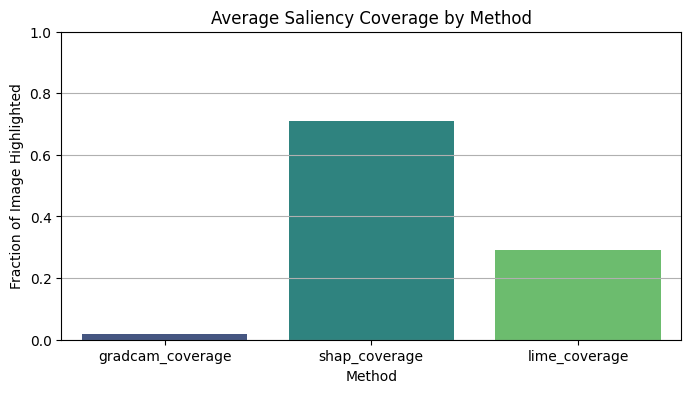

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the results to a DataFrame if not already done
df = pd.DataFrame(results)

# === 1. Print saliency coverage per image ===
print("📋 Per-image saliency coverage:")
display(df[["image", "gradcam_coverage", "shap_coverage", "lime_coverage"]])

# === 2. Compute and print average saliency coverage ===
print("\n📊 Average saliency coverage across all images:")
avg_coverage = df[["gradcam_coverage", "shap_coverage", "lime_coverage"]].mean()
display(avg_coverage)

# === 3. Optional: Bar plot of average saliency coverage ===
plt.figure(figsize=(8, 4))
sns.barplot(
    data=avg_coverage.reset_index(),
    x="index",
    y=0,
    palette="viridis"
)
plt.title("Average Saliency Coverage by Method")
plt.ylabel("Fraction of Image Highlighted")
plt.xlabel("Method")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()


In [20]:
import cv2
import os
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim

def perturb_image(image_np, mask, keep_percent=0.8):
    """Apply mask to keep top attention regions, mask out the rest."""
    heatmap_flat = mask.flatten()
    cutoff = np.percentile(heatmap_flat, 100 * (1 - keep_percent))
    binary_mask = (mask >= cutoff).astype(np.float32)

    binary_mask_resized = cv2.resize(binary_mask, image_np.shape[:2][::-1])
    binary_mask_resized = np.expand_dims(binary_mask_resized, axis=-1)

    perturbed = image_np * binary_mask_resized
    return perturbed

def add_noise(image_np, brightness_factor=1.05, noise_std=0.01):
    """Add slight brightness and Gaussian noise."""
    bright = np.clip(image_np * brightness_factor, 0, 1)
    noise = np.random.normal(0, noise_std, image_np.shape)
    noisy_image = np.clip(bright + noise, 0, 1)
    return noisy_image

# === Main Experiment Loop ===
faithfulness_drops = []
stability_scores = []

for img_path in tqdm(image_paths, desc="Faithfulness & Stability Tests"):
    image = Image.open(img_path).convert('RGB').resize((224, 224))
    image_np = np.array(image).astype(np.float32) / 255.0

    # === Base model confidence ===
    base_tensor = model.transform(image).unsqueeze(0).to(model.device)
    with torch.no_grad():
        base_logits = model.model(base_tensor).logits
    base_conf = torch.softmax(base_logits, dim=1).max().item()

    # === Grad-CAM++ heatmap ===
    heatmap = explain_model(model, str(img_path), discard_ratio=0.1, threshold=0.2, visualize=False)

    # === Faithfulness: Mask top 20% of salient regions ===
    masked_image_np = perturb_image(image_np, heatmap, keep_percent=0.8)
    masked_pil = Image.fromarray((masked_image_np * 255).astype(np.uint8))
    masked_tensor = model.transform(masked_pil).unsqueeze(0).to(model.device)
    with torch.no_grad():
        masked_logits = model.model(masked_tensor).logits
    masked_conf = torch.softmax(masked_logits, dim=1).max().item()

    confidence_drop = base_conf - masked_conf
    faithfulness_drops.append(confidence_drop)

    # === Stability: Compare clean vs noisy heatmaps ===
    noisy_np = add_noise(image_np)
    noisy_pil = Image.fromarray((noisy_np * 255).astype(np.uint8))
    noisy_path = "temp_noisy_img.png"
    noisy_pil.save(noisy_path)

    noisy_heatmap = explain_model(model, noisy_path, discard_ratio=0.1, threshold=0.2, visualize=False)

    # Resize both heatmaps for SSIM comparison
    h1 = cv2.resize(heatmap, (224, 224))
    h2 = cv2.resize(noisy_heatmap, (224, 224))

    # ✅ FIXED: Add data_range=1.0 since heatmaps are floats in [0, 1]
    stability = ssim(h1, h2, data_range=1.0)
    stability_scores.append(stability)

    # Clean up temp file
    os.remove(noisy_path)


Faithfulness & Stability Tests: 100%|██████████| 5/5 [00:02<00:00,  2.36it/s]


In [21]:
print("📉 Perturbation-Based Faithfulness Test")
print(f"Average confidence drop after masking Grad-CAM regions: {np.mean(faithfulness_drops):.4f}")

print("\n🔁 Stability Test with Input Noise")
print(f"Average heatmap SSIM between clean and noisy inputs: {np.mean(stability_scores):.4f}")

📉 Perturbation-Based Faithfulness Test
Average confidence drop after masking Grad-CAM regions: 0.0000

🔁 Stability Test with Input Noise
Average heatmap SSIM between clean and noisy inputs: 0.9413
